In [1]:
import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from scipy.stats import skew

np.warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

# set Jupyter to display ALL output from a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# set pandas and numpy options to make print format nicer
pd.set_option("display.width",100)
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_rows', 500)
np.set_printoptions(linewidth=120, threshold=5000, edgeitems=50, suppress=True)

seed = 42

## Read Loans csv and Create test/train csv files

In [2]:
%%time
print('Reading: loan_stat542.csv into loans dataframe...')

loans = pd.read_csv('loan_stat542.csv')
print('Loans dataframe:', loans.shape)

test_ids = pd.read_csv('Project3_test_id.csv', dtype={'test1':int,'test2':int, 'test3':int,})
print('ids dataframe:', test_ids.shape)

trains = []
tests = []
labels = []
for i, col in enumerate(test_ids.columns):
    trains.append(loans.loc[~loans.id.isin(test_ids[col]),:])
    tests.append( loans.loc[ loans.id.isin(test_ids[col]), loans.columns!='loan_status'])
    labels.append(loans.loc[ loans.id.isin(test_ids[col]), ['id','loan_status']])
    labels[i]["y"] = (labels[i].loan_status != 'Fully Paid').astype(int)
    labels[i].drop('loan_status', axis=1, inplace=True)
    print('Fold', i, trains[i].shape, tests[i].shape, labels[i].shape)

print('Writing train, test, labels csv files...')
# fold=0
# _ = trains[fold].to_csv('train.csv', index=False)
# _ = tests [fold].to_csv('test.csv',  index=False)
# _ = labels[fold].to_csv('label.csv', index=False)
print('Done!')

Reading: loan_stat542.csv into loans dataframe...
Loans dataframe: (844006, 30)
ids dataframe: (253200, 3)
Fold 0 (590806, 30) (253200, 29) (253200, 2)
Fold 1 (590806, 30) (253200, 29) (253200, 2)
Fold 2 (590806, 30) (253200, 29) (253200, 2)
Writing train, test, labels csv files...
Done!
CPU times: user 3.46 s, sys: 401 ms, total: 3.86 s
Wall time: 3.87 s


## Read and process train and test dataframes

In [3]:
def process(data):        
    data['emp_length'] = data.emp_length.fillna('Unknown').str.replace('<','LT')
    data['dti'] = data.dti.fillna(0)
    data['revol_util'] = data.revol_util.fillna(0)
    data['mort_acc'] = data.mort_acc.fillna(0)
    data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.fillna(0)
    temp = pd.to_datetime(data.earliest_cr_line)
    data['earliest_cr_line'] = temp.dt.year*12 - 1950*12 + temp.dt.month
    data.drop(['emp_title','title','zip_code','grade','fico_range_high'], axis=1, inplace=True)
    return data

def logloss(y, p):
    loglosses = np.where(y==1, -np.log(p+1e-15), -np.log(1-p+1e-15))
    return np.mean(loglosses)

def prep_train_test(train, test):    
    train = process(train)
    X_train = train.drop(['loan_status'], axis=1)
    X_train = pd.get_dummies(X_train) # create dataframe with dummy variables replacing categoricals
    X_train = X_train.reindex(sorted(X_train.columns), axis=1) # sort columns to be in same sequence as test
    y_train = (train.loan_status!='Fully Paid').astype(int)

    test = process(test)
    X_test = pd.get_dummies(test) # create dataframe with dummy variables replacing categoricals

    all_columns = X_train.columns.union(X_test.columns) # add columns to test that are in train but not test
    X_test = X_test.reindex(columns=all_columns).fillna(0)
    X_test = X_test.reindex(sorted(X_train.columns), axis=1) # sort columns to be in same sequence at train

    return X_train, y_train, X_test

In [26]:
%%time 
import time
seed=42
models = [
    LogisticRegression(penalty='l1',C=1, random_state=seed),
    
#     GradientBoostingClassifier(max_features='sqrt', learning_rate=0.055, n_estimators=780, max_depth=7, 
#                                min_samples_leaf=2, subsample=0.9, min_samples_split=4,
#                                min_weight_fraction_leaf=0, random_state=seed),
    
    xgb.XGBClassifier(learning_rate=0.037, n_estimators=860, min_child_weight=8, max_depth=7, gamma=0.3,
                       subsample=0.52, colsample_bytree=0.92, reg_lambda=0.67, reg_alpha=0.03,  
                       objective= 'binary:logistic', n_jobs=-1, random_state=seed, eval_metric='logloss'),
]
    
num_models, num_folds = len(models), len(test_ids.columns)
errors = np.zeros([num_models, num_folds])

for fold in range(num_folds):
    np.random.seed(seed=seed)
    train = trains[fold].copy()
    test  = tests [fold].copy()
    label = labels[fold].copy()
    fraction = 1
    if fraction < 1:
        train = train.sample(frac=fraction, random_state=seed)
        test  =  test.sample(frac=fraction*4, random_state=seed)
    print()
    X_train, y_train, X_test = prep_train_test(train, test)
#     print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    for i, model in enumerate(models):
        start_time = time.time()
        _ = model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)[:,1]
        y_test = pd.merge(tests[fold][['id']], label, how='left', on='id')
        errors[i, fold] = logloss(y_test.y, probs)
        print('{:26.26} Fold={}, Runime={:8.2f} seconds, logloss={:8.5f}'.format(
            type(model).__name__, fold, round(time.time()-start_time,2), errors[i,fold]))
#         df = pd.DataFrame({'id': test.id, 'prob': probs.round(5)})
#         df.to_csv('mysubmission'+str(i+1)+'.txt', index=False)
#         print('Created mysubmission'+str(i+1)+'.txt, rows=', df.shape[0]) 

print("\nSUMMARY:")
for i, m in enumerate(models):
    print('{:26.26} mean logloss={:8.5f}'.format(type(m).__name__, errors[i,:].mean()))


LogisticRegression         Fold=0, Runime=    3.42 seconds, logloss= 0.45552
GradientBoostingClassifier Fold=0, Runime=  796.09 seconds, logloss= 0.44001
XGBClassifier              Fold=0, Runime=  677.12 seconds, logloss= 0.43903

LogisticRegression         Fold=1, Runime=    3.95 seconds, logloss= 0.45645
GradientBoostingClassifier Fold=1, Runime= 1232.59 seconds, logloss= 0.44165
XGBClassifier              Fold=1, Runime=  832.71 seconds, logloss= 0.44060

LogisticRegression         Fold=2, Runime=    3.33 seconds, logloss= 0.45575
GradientBoostingClassifier Fold=2, Runime=  795.00 seconds, logloss= 0.44041
XGBClassifier              Fold=2, Runime=  573.71 seconds, logloss= 0.43956

SUMMARY:
LogisticRegression         mean logloss= 0.45591
GradientBoostingClassifier mean logloss= 0.44069
XGBClassifier              mean logloss= 0.43973
CPU times: user 4h 14min 55s, sys: 1min 5s, total: 4h 16min
Wall time: 1h 22min 49s


## Model Tuning with skopt

In [17]:
from skopt import gp_minimize, gbrt_minimize
from skopt.plots import plot_convergence
import datetime, warnings

def objective(values):    
    index = str(values)
    if index in cache:
        print('GET FROM CACHE:', index, round(cache[index],4))
        return cache[index]
    if model_type == 'LogisticRegression':
        params = {'penalty': values[0], 'C': values[1],}
        model = LogisticRegression(**params, random_state=seed, n_jobs=-1)
        
#     if model_type == 'RandomForestClassifier':
#         params = {'n_estimators': values[0], 'max_features': values[1], 'max_depth': values[2],}
#         model = RandomForestClassifier(**params, n_jobs=-1)
    
    if model_type == 'GradientBoostingClassifier':
        params = {'learning_rate': values[0], 'n_estimators': values[1], 'max_depth': values[2],
                  'min_samples_split': values[3], 'min_samples_leaf': values[4], 
                  'min_weight_fraction_leaf' : values[5], 'subsample': values[6], 'max_features': values[7] }
        model = GradientBoostingClassifier(**params, random_state=seed)
    
    if model_type == 'XGBClassifier':
        params = {'learning_rate': values[0], 'n_estimators': int(values[1]), 'min_child_weight': int(values[2]),
                  'max_depth': int(values[3]), 'gamma': values[4], 'subsample': values[5],
                  'colsample_bytree': values[6], 'lambda': values[7], 'alpha': values[8], 'eval_metric':'logloss'}
        model = xgb.XGBClassifier(**params, random_state=seed, nthread=-1, n_jobs=-1,silent=1)
        
    print(datetime.datetime.now().time().replace(microsecond=0), ', Params',params) 
#     scores = -cross_val_score(model, X_train, y_train, scoring="neg_log_loss", cv=5, n_jobs=-1)
    _ = model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:,1]
    y_test = pd.merge(test[['id']], label, how='left', on='id')

    cache[index] = np.mean( logloss(y_test.y, probs) )
    return cache[index]

In [ ]:
# %%time
import warnings
np.random.seed(seed)
warnings.filterwarnings("ignore", category=UserWarning) # turn off already evaluated errors
params={'LogisticRegression': [ 
                ['l1',],
                (1e-1,1e+1,'uniform'),
                ],
        'GradientBoostingClassifier': [ 
                (0.04, 0.10, 'uniform'),     # learning rate
                (500, 900),                  # n_estimators
                (3, 7),                      # max_depth   
                (2, 5),                      # min_samples_split 
                (2, 5),                      # min_samples_leaf 
                (0, 0.3),                    # min_weight_fraction_leaf 
                (0.8, 1.0,'uniform'),        # subsample 
                ('sqrt',),                   # max_features 
                ],
        'XGBClassifier': [
                (0.01, 0.05, 'uniform'),    # learning_rate 0.05, 0.3,
                (300, 700),                 # n_estimators
                (5, 9),                     # min_child_weight 
                (4, 8),                     # max_depth 3-10
                (0, 0.5,   'uniform'),      # gamma 0-0.4
                (0.4, 1.0, 'uniform'),      # subsample 0.5 - 0.99
                (0.8, 1.0, 'uniform'),      # colsample_bytree 0.5 - 0.99
                (0.8, 1.0, 'uniform'),      # reg_lambda
                (0.0, 0.5, 'uniform'),      # reg_alpha
                ],}

train = trains[0].copy()
test = tests[0].copy()
label = labels[0].copy()
fraction = 1
if fraction < 1:
    train = train.sample(frac=fraction, random_state=seed)
    test  = test.sample(frac=fraction, random_state=seed)
print(train.shape)
X_train, y_train, X_test = prep_train_test(train, test)
print(X_train.shape, y_train.shape, X_test.shape) 

model_types = params.keys()
model_types = ['GradientBoostingClassifier']
for model_type in model_types:
    cache = {}
    space = params[model_type]
    result = gbrt_minimize(objective,space,n_random_starts=15, n_calls=300, random_state=seed,verbose=True,n_jobs=-1)
    print('\n', model_type, ', Best Params=', result.x, ' Best Score=', round(result.fun,6),'\n')
    _ = plt.figure(figsize=(15,8))
    _ = plot_convergence(result, yscale='log')

warnings.filterwarnings("default", category=UserWarning) # turn on already evaluated errors

### GBM best results - sorted

In [ ]:
sorted_d = sorted(cache.items(), key=lambda x: x[1])
temp = []
for i in range(len(sorted_d)):
    temp.append((sorted_d[i][0], round(sorted_d[i][1],5)))
    print('{} {}'.format(round(sorted_d[i][1],5), sorted_d[i][0]))

### XGB best results - sorted

In [ ]:
sorted_d = sorted(cache.items(), key=lambda x: x[1])
temp = []
for i in range(len(sorted_d)):
    temp.append((sorted_d[i][0], round(sorted_d[i][1],5)))
    print('{} {}'.format(round(sorted_d[i][1],5), sorted_d[i][0]))

## Tune XGBoost Model manually with CV 

In [75]:
%%time

XGB_params = {
      'learning_rate':    np.linspace(0.05, 1, 1), # 0.03 to 0.2, tuned to 0.05
      'min_child_weight': np.linspace(5, 10, 1, dtype=int),  # 1 to 6, tuned to 2
      'max_depth':        np.linspace(4, 8, 1, dtype=int), # 3 to 10, tuned to 3
      'gamma':            np.linspace(0.2, 0.4, 1), # 0 to 0.4, tuned to 0
      'subsample':        np.linspace(1, 1, 1),   # 0.6 to 1, tuned to 1.0
      'colsample_bytree': np.linspace(0.75, 1, 1), # 0.6 to 1, tuned to 0.6
      'reg_lambda':       np.linspace(0.25, 0.6, 1),   # 0 to 1, tuned to 1.0
      'reg_alpha':        np.linspace(0.15, 0.5, 1),  # 0 to 1, tuned to 0.5
      'silent':           [1,],
}


train = trains[0].copy()
test = tests[0].copy()
fraction = 0.05
if fraction < 1:
    train = train.sample(frac=fraction, random_state=seed)
    test  =  test.sample(frac=fraction*4, random_state=seed)
print(train.shape, test.shape)
X_train, y_train, X_test= prep_train_test(train, test)
print(X_train.shape, y_train.shape, X_test.shape)

tune_cv=False #     perform CV just to get number of boost rounds/estimators before using GridSearchCV
if tune_cv:
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    cvresult = xgb.cv(objective=binary:logistic, learning_rate=0.05,min_child_weight=5, max_depth=4, gamma=0.2, 
                      subsample=1.0, colsample_bytree=0.75, reg_lambda=0.25, reg_alpha=0.15, silent=1, 
                      xgtrain, num_boost_round=1000, early_stopping_rounds=50, nfold=10, 
                      metrics='logloss', verbose_eval=10, show_stdv=False)
else:
    XGBbase = xgb.XGBClassifier(n_estimators=150, objective= 'binary:logistic', random_state=seed, n_jobs=-1)
    XGBmodel = GridSearchCV(XGBbase, cv=10, n_jobs=-1, param_grid=XGB_params, scoring='neg_log_loss' ,verbose=5)
    _ = XGBmodel.fit(X_train, y_train)
    print(XGBmodel.best_estimator_)
    print(XGBmodel.best_params_)
    print(-round(XGBmodel.best_score_,6))
    
# fig, ax = plt.subplots(1,1,figsize=(16,26))
# _ = xgb.plot_importance(model, ax=ax)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    9.8s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   11.0s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.3s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0.2, learning_rate=0.05,
       max_delta_step=0, max_depth=4, min_child_weight=5, missing=None,
       n_estimators=150, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0.15,
       reg_lambda=0.25, scale_pos_weight=1, seed=None, silent=1,
       subsample=1.0)
{'colsample_bytree': 0.75, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'reg_alpha': 0.15, 'reg_lambda': 0.25, 'silent': 1, 'subsample': 1.0}
0.432885
CPU times: user 6.58 s, sys: 58.9 ms, total: 6.64 s
Wall time: 21.9 s


# BELOW HERE IS MISC STUFF

In [101]:
# rejected models
#     KNeighborsClassifier(500), #  tuned on 5% of data
#     SVC(gamma='auto', C=1, probability=True, random_state=seed), # quite slow
#     DecisionTreeClassifier(max_depth=2, random_state=seed),
#     RandomForestClassifier(n_estimators=300, random_state=seed), 
#     AdaBoostClassifier(random_state=seed),
#     GaussianNB(),
#     LinearDiscriminantAnalysis(),

In [40]:
temp = X_train.corr()
temp = temp[temp>0.50]
temp.values[[np.arange(len(temp.columns))]*2] = np.NaN
temp = temp.dropna(how='all', axis=0)
temp = temp.dropna(how='all', axis=1)
temp

/Users/graham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


,installment,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,total_acc
installment,NaN,0.953484,NaN,NaN,NaN,NaN
loan_amnt,0.953484,NaN,NaN,NaN,NaN,NaN
open_acc,NaN,NaN,NaN,NaN,NaN,0.691259
pub_rec,NaN,NaN,NaN,NaN,0.666228,NaN
pub_rec_bankruptcies,NaN,NaN,NaN,0.666228,NaN,NaN
total_acc,NaN,NaN,0.691259,NaN,NaN,NaN


In [19]:
m1 = models[-1]
df = pd.DataFrame({'id': test.id, 'prob': probs.round(11)})
df.to_csv('mysubmission1.txt', index=False)
print('Created mysubmission1.txt, rows=', df.shape[0], ', Model=', type(m1).__name__) 

m2 = models[-1]
df = pd.DataFrame({'id': test.id, 'prob': probs.round(11)})
df.to_csv('mysubmission2.txt', index=False)
print('Created mysubmission2.txt, rows=', df.shape[0], ', Model=', type(m2).__name__) 

m3 = models[-1]
df = pd.DataFrame({'id': test.id, 'prob': probs.round(11)})
df.to_csv('mysubmission3.txt', index=False)
print('Created mysubmission3.txt, rows=', df.shape[0], ', Model=', type(m3).__name__) 

Created mysubmission1.txt, rows= 10128 , Model= GradientBoostingClassifier
Created mysubmission2.txt, rows= 10128 , Model= GradientBoostingClassifier
Created mysubmission3.txt, rows= 10128 , Model= GradientBoostingClassifier


## consolidation checking

In [ ]:
%%time
loans['emp_title'] = loans.emp_title.fillna('_unknown').str.lower()
loans['emp_title1'] = categorise_emp_title(loans.emp_title)
loans['default'] = (loans.loan_status!='Fully Paid').astype(int)
g1 = loans.groupby(['emp_title','emp_title1'])['default'].agg(['sum','count'])
g1.columns = ['sum1','count1']
g1['rate1'] = g1['sum1'] / g1['count1']
g1 = g1.sort_values("rate1", ascending=False)

## Create Two Predictions  files from test.csv

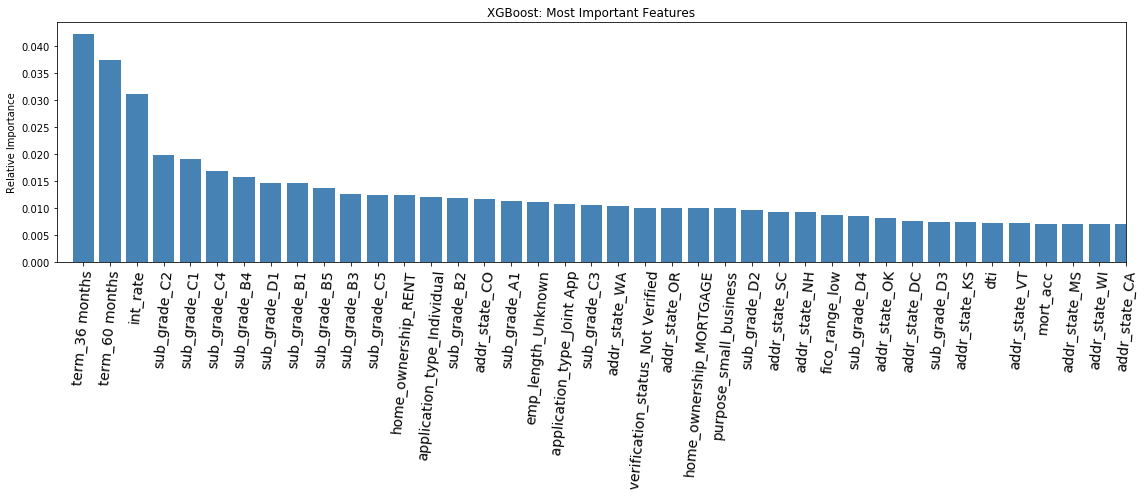

In [24]:
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances*-1)
num_features = 40
indices = indices[0:num_features]
_ = plt.figure(figsize=(16,7))
_ = plt.title('XGBoost: Most Important Features')
_ = plt.bar(range(len(indices)), importances[indices], color='steelblue')
_ = plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=85, fontsize = 14)
_ = plt.ylabel('Relative Importance')
_ = plt.xlim(-1,num_features-1)
_ = plt.tight_layout()
_ = plt.savefig('features.png',dpi=100)

In [ ]:
np.random.seed(seed)

# TRAIN LASSO MODEL AND GENERATE SUBMISSION FILE
model = ElasticNet(alpha=0.001, l1_ratio=0.4, max_iter=5000, tol=0.0001, random_state=seed),
_ = model.fit(X_train, y_train)
XGBpreds = model.predict(X_test)
XGB_df = pd.DataFrame({'PID': y_test.index, 'Sale_Price': np.expm1(XGBpreds).round(1)})
XGB_df.to_csv('mysubmission1.txt', index=False)
print('Created mysubmission1.txt, rows=', XGB_df.shape[0], 
      ', Model=', type(model).__name__, ', RMSElogPrice =', round( rmse(y_test, XGBpreds),6 ))

# TRAIN GBM MODEL AND GENERATE SUBMISSION FILE
model = GradientBoostingRegressor(learning_rate=0.03, n_estimators=550, max_depth=5, min_samples_split=4,
            min_samples_leaf=3, min_weight_fraction_leaf=0, subsample=0.64, max_features='sqrt', random_state=seed)
_ = model.fit(X_train, y_train)
ENet_preds = model.predict(X_test)
ENet_df = pd.DataFrame({'PID': y_test.index, 'Sale_Price': np.expm1(ENet_preds).round(1)})
ENet_df.to_csv('mysubmission2.txt', index=False)
print('Created mysubmission2.txt, rows=', XGB_df.shape[0], 
      ', Model=', type(model).__name__, ', RMSElogPrice =', round( rmse(y_test, ENet_preds),6 ))

# RE-READ SUBMISSION FILES AND CHECK FOR CORRECTNESS
temp = pd.read_csv('mysubmission1.txt')
print('\nChecking mysubmission1 file, RMSE=', round(rmse(np.log1p(temp.Sale_Price), y_test.values),6) )
temp = pd.read_csv('mysubmission2.txt')
print('Checking mysubmission2 file, RMSE=', round(rmse(np.log1p(temp.Sale_Price), y_test.values),6) )


**loan_amnt**: could round by 100 to 500 as categorical (NO IMPROVE)

**term**: ok as-is, two values and categorical (object)

**int_rate**: could round by 0.1 to 0.5 as categorical, Note: 629 values, 5.31 to 30.99 (TINY IMPROVE)

**installment**: could try log transform but unlikely, Note lots of values from 4.93 to 1714.54

**grade**: ok as-is, 7 values categorical

**sub_grade**: ok as-is, 35 values categorical

**emp_title**: emp_title.fillna('unknown').lower() - tuning or consolidation didnt help results

**emp_length**: emp_length.fillna('unknown'), otherwise ok as-is, 11 values categorical

**home_ownership**: ok as-is, 6 values categorical

**annual_inc**: Note: 0 to 9,550,000, could try log1p transform but probably ok as-is

**verification_status**: ok as-is, 3 values categorical

**loan_status**: On train only: (train.loan_status != 'Fully Paid').astype(int)

**purpose**: ok as-is 14 values categorical

**title**: title.fillna('Unknown').lower() - tuning or consolidation didnt help results

**zip_code**: ok as-is, consolidation made it worse

**addr_state**: ok as-is, 51 values categorical

**dti**: is a ratio of debt payment to income, Note: 5362 values from -1 to 999 (only 1 is negative)

**earliest_cr_line**: maybe convert to an integer, currently mon-yyyy, from apr-1955 to sep-2014

**fico_range_low**: ok as-is, integer from 625 to 845 in steps of 5 (40 values)

**fico_range_high**: ok as-is, integer from 629 to 850 in steps of 5 (40 values)

**open_acc**: ok as-is, integer from 0 to 90, 78 values, but some are rare so could consolidate infreq values

**pub_rec**: ok as-is, integer from 0 to 86, 30 values, but some are rare so could consolidate infreq values

**revol_bal**: ok as-is, float from 0 to 2,568,995, could try log1p transform

**revol_util**: data.revol_util.fillna(0 or 9999), otherwise ok as-is, 1319 values from 0 to 892.3

**total_acc**: ok as-is, 133 values from 2 to 176

**initial_list_status**: ok as-is, categorical 2 values

**application_type:** ok as-is, categorical 2 values

**mort_acc**: data.mort_acc.fillna(0 or 9999), otherwise ok. 38 values from 0 to 51

**pub_rec_bankruptcies**: data.pub_rec_bankruptcies.fillna(0 or 999) 10 values from 0 to 12